# Notebook 1: Construction Drag Analysis

Goal: Mine the PRIS data to find the truth about how long it takes to build a reactor.

Logic:

* Load PRIS Data.

* Calculate Construction Duration = Grid Connection Date - Construction Start Date.

* Filter for valid data (exclude cancelled/never finished).

* Segment by Era (Is it getting harder to build?) and Region (Is Asia faster than the West?).

--- Notebook 1: Construction Drag Analysis ---
Data loaded successfully.

--- Construction Duration Statistics (Years) ---
count    20737.000000
mean         6.833779
std          3.427387
min          1.798768
25%          4.714579
50%          5.864476
75%          8.104038
max         42.754278
Name: Construction_Years, dtype: float64

--- Median Construction Time by Era ---
Era
1. Golden Era (<1980)        5.889117
2. Stagnation (1980-1999)    5.776865
3. Modern Era (2000+)        5.519507
Name: Construction_Years, dtype: float64


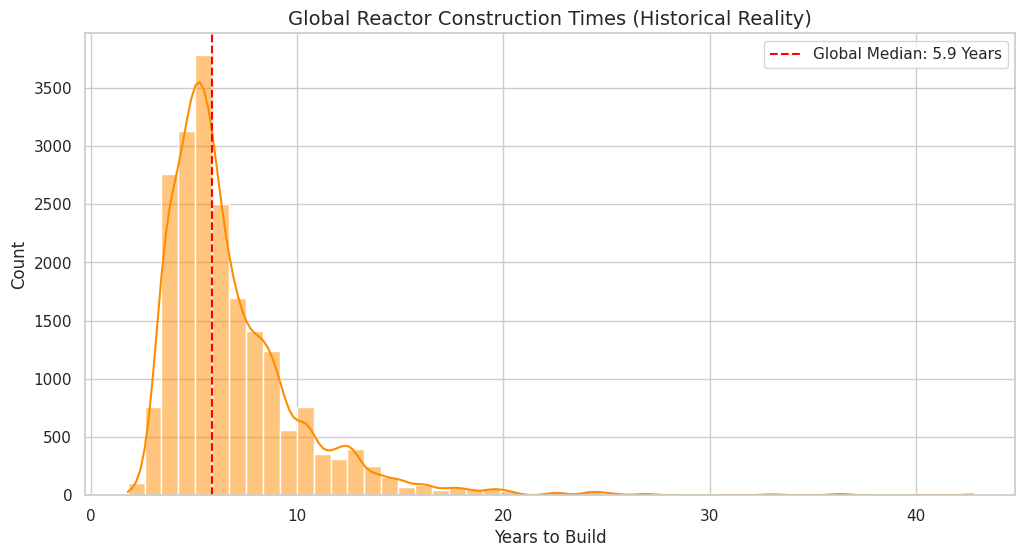

/tmp/ipython-input-2880620738.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_const, x='Era', y='Construction_Years', palette='Set2', order=['1. Golden Era (<1980)', '2. Stagnation (1980-1999)', '3. Modern Era (2000+)'])


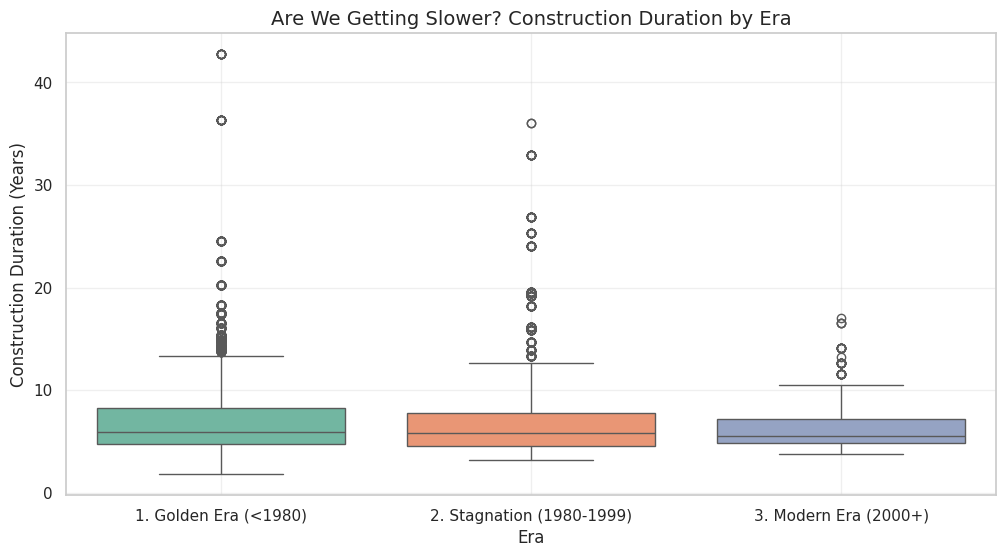

/tmp/ipython-input-2880620738.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=modern_top5, x='Country', y='Construction_Years', palette='magma')


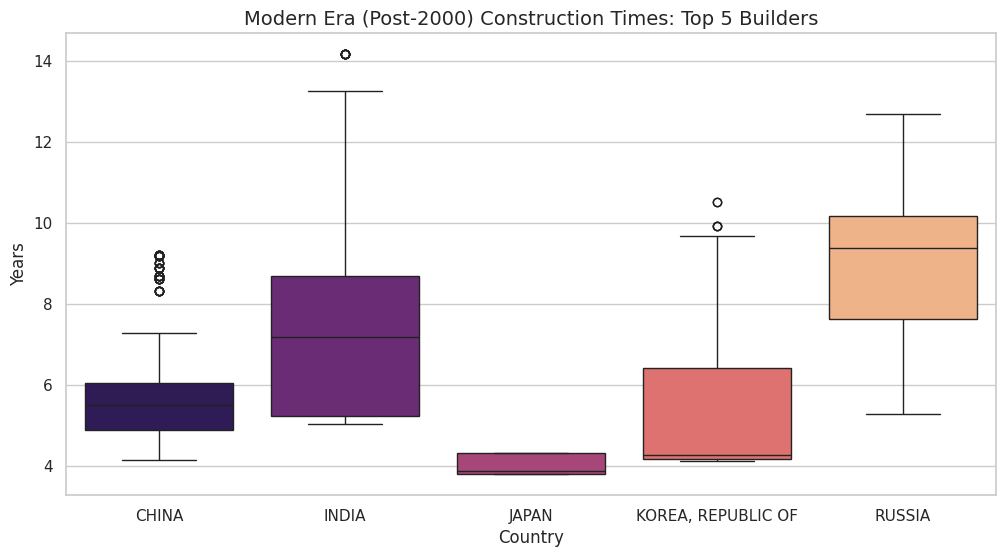

Construction data saved to 'construction_durations.csv'.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 1: Construction Drag Analysis ---")

# 1. Load the Dataset
file_path = 'Reactor Database - Pris.xlsx'
try:
    df_raw = pd.read_excel(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File {file_path} not found.")

# 2. Clean & Calculate Construction Duration
# We need 'Construction Start Date' and 'Grid Connection Date'
date_cols = ['Construction Start Date', 'Grid Connection Date']

for col in date_cols:
    df_raw[col] = pd.to_datetime(df_raw[col], format='%d %b, %Y', errors='coerce')

# Create a clean dataframe for construction analysis
df_const = df_raw.dropna(subset=date_cols).copy()

# Calculate Duration in Months and Years
df_const['Construction_Days'] = (df_const['Grid Connection Date'] - df_const['Construction Start Date']).dt.days
df_const['Construction_Months'] = df_const['Construction_Days'] / 30.44
df_const['Construction_Years'] = df_const['Construction_Days'] / 365.25

# Filter out bad data (negative times or unrealistic < 1 year)
df_const = df_const[df_const['Construction_Years'] > 1].copy()

# 3. Segment by Era (When was construction STARTED?)
# This helps us see if we are "forgetting how to build"
df_const['Start_Year'] = df_const['Construction Start Date'].dt.year

def categorize_era(year):
    if year < 1980: return '1. Golden Era (<1980)'
    elif year < 2000: return '2. Stagnation (1980-1999)'
    else: return '3. Modern Era (2000+)'

df_const['Era'] = df_const['Start_Year'].apply(categorize_era)

# 4. Analyze the Stats
print("\n--- Construction Duration Statistics (Years) ---")
print(df_const['Construction_Years'].describe())

print("\n--- Median Construction Time by Era ---")
print(df_const.groupby('Era')['Construction_Years'].median())

# 5. Visualization

# Fig 1: Histogram of Construction Times
plt.figure(figsize=(12, 6))
sns.histplot(data=df_const, x='Construction_Years', bins=50, kde=True, color='darkorange')
plt.axvline(df_const['Construction_Years'].median(), color='red', linestyle='--', label=f"Global Median: {df_const['Construction_Years'].median():.1f} Years")
plt.title('Global Reactor Construction Times (Historical Reality)', fontsize=14)
plt.xlabel('Years to Build')
plt.legend()
plt.show()

# Fig 2: Boxplot by Era (The "Learning Curve" or "Forgetting Curve"?)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_const, x='Era', y='Construction_Years', hue='Era', palette='Set2', order=['1. Golden Era (<1980)', '2. Stagnation (1980-1999)', '3. Modern Era (2000+)'], legend=False)
plt.title('Are We Getting Slower? Construction Duration by Era', fontsize=14)
plt.ylabel('Construction Duration (Years)')
plt.grid(True, alpha=0.3)
plt.show()

# Fig 3: Modern Era Regional Comparison (Where should we build?)
modern_era = df_const[df_const['Era'] == '3. Modern Era (2000+)']
top_countries = modern_era['Country'].value_counts().head(5).index
modern_top5 = modern_era[modern_era['Country'].isin(top_countries)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=modern_top5, x='Country', y='Construction_Years', hue='Country', palette='magma', legend=False)
plt.title('Modern Era (Post-2000) Construction Times: Top 5 Builders', fontsize=14)
plt.ylabel('Years')
plt.show()

# 6. Save for later Notebooks
# We will use these distributions for our Monte Carlo simulation later
df_const.to_csv('construction_durations.csv', index=False)
print("Construction data saved to 'construction_durations.csv'.")